In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d import Axes3D
from skfda.representation.basis import BSpline
from scipy.ndimage import gaussian_filter
from matplotlib import cm
import seaborn as sns
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Read in data

In [2]:
with open('ECG200TRAIN', 'r') as fh:
    train = fh.readlines()
    
with open('ECG200TEST', 'r') as fh:
    test = fh.readlines()

### Convert data to numpy arrays

In [3]:
train = np.array([[float(x) for x in row.split(',')] for row in train])
test = np.array([[float(x) for x in row.split(',')] for row in test])

### Separate independent variables from dependent variable

In [4]:
Xtrain = train[:, 1:]
ytrain = np.array([x[0] for x in train[:, :1]])

In [5]:
Xtest = test[:, 1:]
ytest = np.array([x[0] for x in test[:, :1]])

### Creat class for Functional PCA
Parts of this code was provided by Johnathan Tay and his refactored R code to Python. His refactorizations can be found at

https://github.gatech.edu/jtay6/IYSE8803-Examples-Py/blob/master/Module%201/Examples1.py#L362

In [6]:
class FPCA:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        #domain is linear space from 0 to 1 with as many points as columns in x
        self.domain = np.linspace(0,1,x.shape[1])
        
    def fit_splines(self, knots, degree, show_fit=False):
        #knots attribute
        self.knots = knots
        
        #skfda BSpline object expects degree + 1 - if you want 3rd degree, must past 4
        self.degree = degree + 1
        
        #fit bspline object
        self.bss = BSpline(knots=self.knots, order=self.degree)
        
        #evaluate basis functions across domain
        self.H = self.bss.evaluate(self.domain)
        
        #code borrowed from Johnathan Tay
        self.H_stacked = np.tile(self.H, self.x.shape[0]).T
        
        #code borrowed from Johnathan Tay
        self.X_stacked = self.x.ravel().reshape(-1,1)
        
        #code borrowed from Johnathan Tay
        
        self.beta = np.linalg.lstsq(self.H_stacked, self.X_stacked, rcond=None)[0]
        
        #code borrowed from Johnathan Tay
        self.mu_hat = self.H.T.dot(self.beta)
        
        if show_fit:
            plt.figure(figsize=(15,8))
            for x in Xtrain:
                plt.plot(x)

            plt.plot(self.mu_hat, lw='6', label='mu',path_effects=[pe.Stroke(linewidth=10, foreground='k'), pe.Normal()])
            plt.legend()
            plt.show()
            
        return self
            
     
        
    def PCA(self, n_components=None):
        #center the data from the line of best fit of all curves (mean curve)
        #code borrowed from Johnathan Tay
        self.diffs = self.x - self.mu_hat.T
        
        #Smooth out covariance matrix
        #code borrowed from Johnathan Tay
        self.Cov = gaussian_filter(np.cov(self.diffs.T), sigma=7)
        
        #used to visualize explained variance for determination of the proper number of components needed
        if n_components == None:
            self.pca = decomposition.PCA()

            self.pca.fit(self.Cov)

            var = self.pca.explained_variance_
            fig = plt.figure(figsize=(15,8))
            plt.plot(range(len(var)), var, marker='o')
            plt.xlabel('Number of Components')
            plt.ylabel('Explained Variance')
            plt.title('PCA ELbow Chart')
            plt.show()
        else:
            #fit and return desired number of principal components
            self.pca = decomposition.PCA(n_components=n_components)
            self.pca.fit(self.Cov)
            
            self.FPC_scores = self.pca.transform(self.diffs)
            
    def train(self, clf):
        #train provided classifier on transformed xtrain data
        self.clf = clf()
        self.clf.fit(self.FPC_scores, self.y)
        
    def predict(self, x=None, predict_train_data=False):
        #return predictins on train data
        if predict_train_data:
            preds = self.clf.predict(self.FPC_scores)
            return preds
        
        #return predictions on new data
        else:
            preds = self.clf.predict(x)
            return preds
        
        
        
    def transform(self,x):
        #transform new data to proper orientation
        diffs = x - self.mu_hat.T
        FPC_scores = self.pca.transform(diffs)
        
        return FPC_scores
        
           
        
        
        
        
        

### Create a class for BSpline transformation and prediction
Parts of this code was provided by Johnathan Tay and his refactored R code to Python. His refactorizations can be found at

https://github.gatech.edu/jtay6/IYSE8803-Examples-Py/blob/master/Module%201/Examples1.py#L362

In [7]:
class fBSplines:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        #domain is linear space from 0 to 1 with as many points as columns in x
        self.domain = np.linspace(0,1,x.shape[1])
        
    def fit_splines(self, knots, degree):
        self.knots = knots
        #skfda BSpline object expects degree + 1 - if you want 3rd degree, must past 4
        self.degree = degree + 1
        
        self.bss = BSpline(knots=self.knots, order=self.degree)
        self.H = self.bss.evaluate(self.domain)
        
        
        #code borrowed from Johnathan Tay
        self.betas = np.linalg.lstsq(self.H.T, self.x.T, rcond=None)[0].T
        
            
        return self
            
     
   
    def train(self, clf):
        #train provided classifier on transformed xtrain
        self.clf = clf()
        self.clf.fit(self.betas, self.y)
        
    def predict(self, x=None, predict_train_data=False):
        #predict on training set
        if predict_train_data:
            preds = self.clf.predict(self.betas)
            return preds
        
        #predict on new data
        else:
            preds = self.clf.predict(x)
            return preds
        
        
        
    def transform(self,x):
        #transform new data with respect to created basis functions
        betas = np.linalg.lstsq(self.H.T, x.T, rcond=None)[0].T
        return betas

### Visualize data

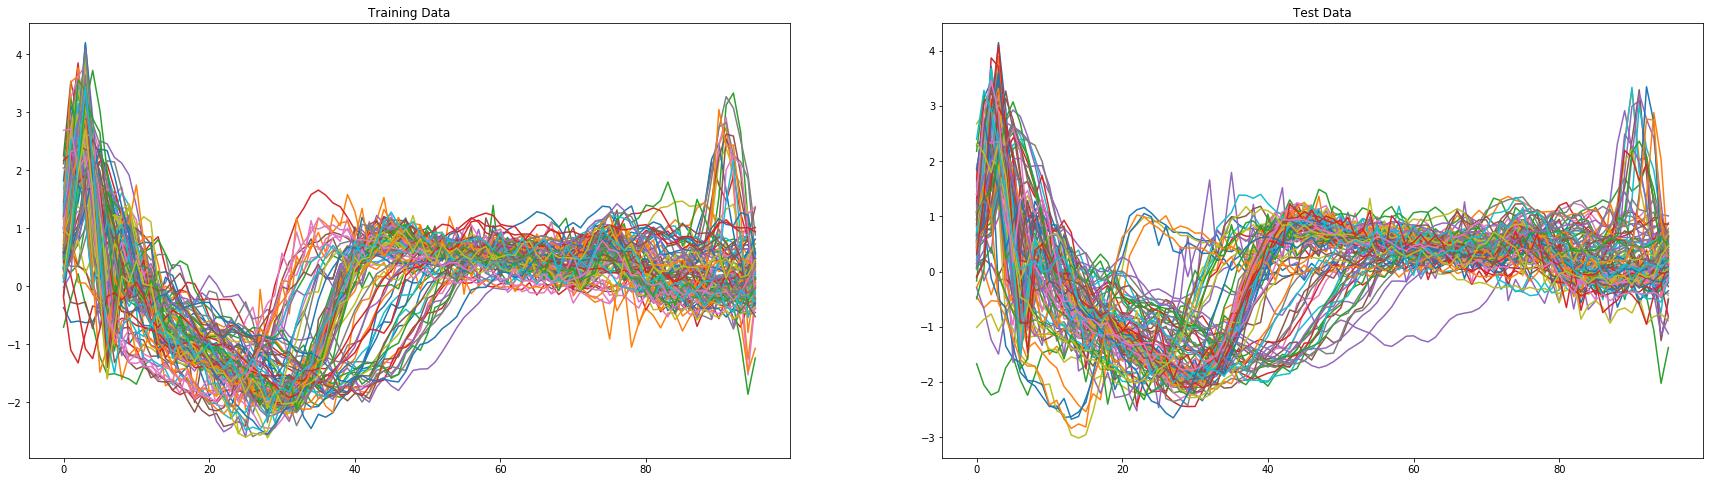

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,8))
ax1 = plt.subplot(121)
for x in Xtrain:
    ax1.plot(x)
ax1.set_title('Training Data')

ax2 = plt.subplot(122)
for x in Xtest:
    ax2.plot(x)
ax2.set_title('Test Data')
plt.show()

## Pepare data for prediction using b-spline basis functions

#### Initial considerations
* Initially let's start off both approaches with 8 knots and adjust later to see how knot placement affects model accuracy. 
* we will fit the splines for both approaches witha 3rd degree polynomial as well. Again, we will adjust later to determine the effects of polynomial degree on model accuracy
* Classifier will be a Random Forest Classifier

In [9]:
knots = np.linspace(0,1,8)
degree = 3
clf = RandomForestClassifier

### Create a functional Bspline object and fit bsplines basis functions on each data row using 8 knots and degree 3 polynomial

In [10]:
#instantiate and generate basis functions as well as find coefficients for basis functions
bs = fBSplines(x=Xtrain, y=ytrain).fit_splines(knots=knots, degree=degree)

In [11]:
# Train Classifier on basis function coefficients
bs.train(clf=clf)

### Create a FPCA object and fit basis function using 8 knots and degree 3 polynomial
In the FPCA method we fit Bsplines and solve for coefficients on the basis functions for line of best fit on all data curves. This serves as the mean of all curves across the entire domain. This mean is then used to center all data points across the domain with respect to the found mean. I've implemetned a parameter that allows for the visualization of the line of best fit (mean) of all data curves

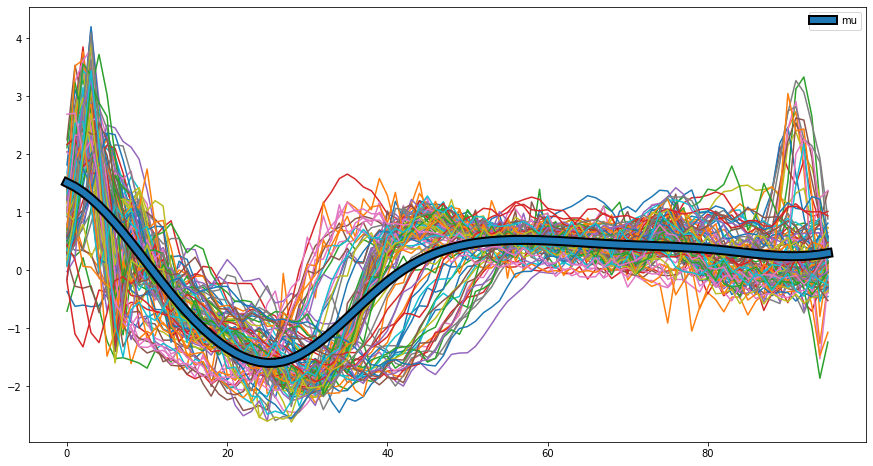

In [12]:
fpca = FPCA(x=Xtrain, y=ytrain).fit_splines(knots=knots, degree=degree, show_fit=True)

### Determine best number of principal components
We must supply the number of components we wish to extract for classification. In order to determine the optimal components, we can plot # of components vs explained variance. The rule of thumb is to pick the number of componenets that makes the "elbow" of the chart. I've implemented functionality that plots number of components vs explained variance

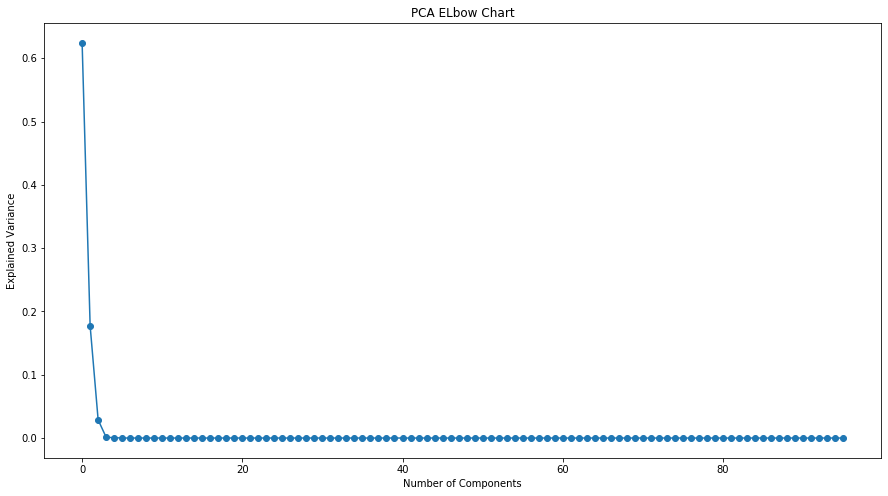

In [13]:
# Determine the best number of principal components to use
fpca.PCA()

#### 3 components seems sufficient
From the Elbow chart above, we can see that the first 3 components explains the majority of the variance. Lets see how much variance is explained up to the first 10 principal components

In [14]:
tot = 0
for pos, var in enumerate(fpca.pca.explained_variance_[:10]):
    tot += var
    print('Variance explained by first {} components: {}'.format(pos, str(round(tot,5)*100) + '%'))

Variance explained by first 0 components: 62.452%
Variance explained by first 1 components: 80.181%
Variance explained by first 2 components: 83.04899999999999%
Variance explained by first 3 components: 83.17099999999999%
Variance explained by first 4 components: 83.22500000000001%
Variance explained by first 5 components: 83.23%
Variance explained by first 6 components: 83.231%
Variance explained by first 7 components: 83.231%
Variance explained by first 8 components: 83.231%
Variance explained by first 9 components: 83.231%


#### It's evident that the first 3 principal components explains 83% of the variance, then rate of var explained attenuates drastically from there. Let's stick with the first 3 principal components to train the classifier on

In [15]:
#Extract first 3 principal components
fpca.PCA(n_components=3)

In [16]:
#Train the classifier on the first 3 principal components
fpca.train(clf)

## Evaluation of each method on the Training Set

In [17]:
#predictions from bsplines
bs_preds = bs.predict(predict_train_data=True)

#predictions from fpca
fpca_preds = fpca.predict(predict_train_data=True)

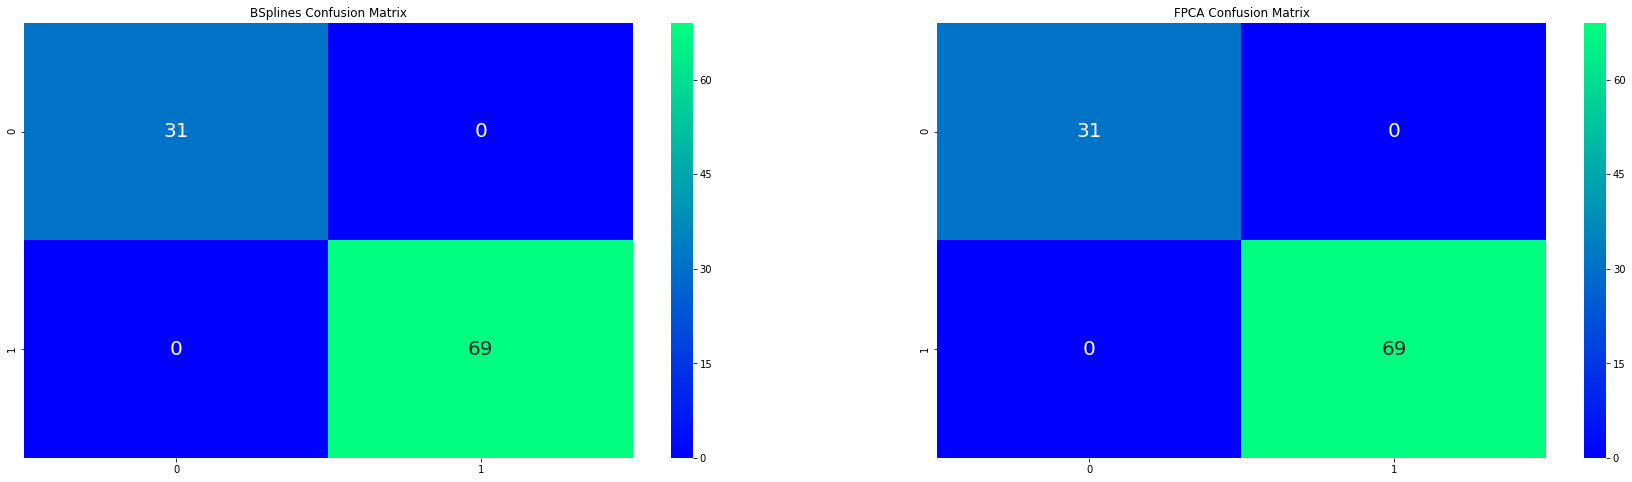

BSplines Accuracy: 100.0%
FPCA Accuracy: 100.0%


In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,8))
ax1=plt.subplot(121)
sns.heatmap(confusion_matrix(ytrain,bs_preds), annot=True, cmap='winter',annot_kws={"fontsize":20}, ax=ax1)
plt.title('BSplines Confusion Matrix')

ax2 = plt.subplot(122)
sns.heatmap(confusion_matrix(ytrain,fpca_preds), annot=True, cmap='winter',annot_kws={"fontsize":20}, ax=ax2)
plt.title('FPCA Confusion Matrix')
plt.show()

print('BSplines Accuracy: {}'.format(str(accuracy_score(ytrain, bs_preds) * 100) + '%'))
print('FPCA Accuracy: {}'.format(str(accuracy_score(ytrain, fpca_preds) * 100) + '%'))

### Results on Training Set - Evaluation on Test Set
We are achieving 100% accuracy for both methods on the training data with 8 knots and degree polynomial of 3. This also includes the first 3 principal components for the FPCA method. Let's assess how much bias/variance each classifier is experiencing with respect to the test set

First we must transform the test data with respect to the basis functions we created using the training data for Bsplines method, and transform the data with respect to the mean curve and principal components we found using the training data for the FPCA method

In [19]:
Xtest_bs = bs.transform(Xtest)
Xtest_fpca = fpca.transform(Xtest)

In [20]:
#predict on test data
bs_preds = bs.predict(Xtest_bs)
fpca_preds = fpca.predict(Xtest_fpca)

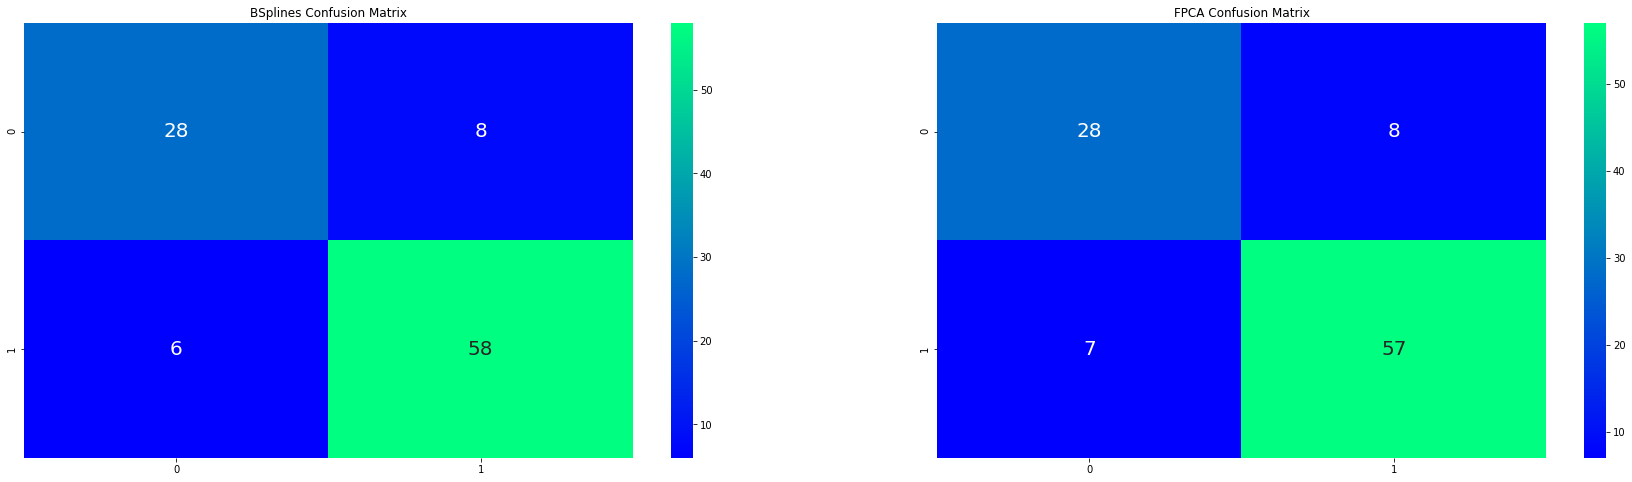

BSplines Accuracy: 86.0%
FPCA Accuracy: 85.0%


In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,8))
ax1=plt.subplot(121)
sns.heatmap(confusion_matrix(ytest,bs_preds), annot=True, cmap='winter',annot_kws={"fontsize":20}, ax=ax1)
plt.title('BSplines Confusion Matrix')

ax2 = plt.subplot(122)
sns.heatmap(confusion_matrix(ytest,fpca_preds), annot=True, cmap='winter',annot_kws={"fontsize":20}, ax=ax2)
plt.title('FPCA Confusion Matrix')
plt.show()

print('BSplines Accuracy: {}'.format(str(accuracy_score(ytest, bs_preds) * 100) + '%'))
print('FPCA Accuracy: {}'.format(str(accuracy_score(ytest, fpca_preds) * 100) + '%'))

### Results on Test Set
As we can see above both methods are giving exceptional results. However the BSplines method is achiving 90% accuracy in comparison to FPCA's 82%. Let's now assess how adjusting polynomial degree affects accuracy

## Effects of polynomial degree on Accuracy

In [22]:
degrees = range(1,11)
bs_train_accs = []
fpca_train_accs = []

bs_test_accs = []
fpca_test_accs= []

for degree in degrees:
    bs = fBSplines(x=Xtrain, y=ytrain).fit_splines(knots=knots, degree=degree)
    bs.train(clf=clf)
    
    fpca = FPCA(x=Xtrain, y=ytrain).fit_splines(knots=knots, degree=degree, show_fit=False)
    fpca.PCA(n_components=3)
    fpca.train(clf)
    
    bs_train_preds = bs.predict(predict_train_data=True)
    fpca_train_preds = fpca.predict(predict_train_data=True)
    
    acc_train_bs = accuracy_score(ytrain, bs_train_preds)
    acc_train_fpca = accuracy_score(ytrain, fpca_train_preds)
    
    bs_train_accs.append(acc_train_bs)
    fpca_train_accs.append(acc_train_fpca)
    
    
    
    Xtest_bs = bs.transform(Xtest)
    Xtest_fpca = fpca.transform(Xtest)
    
    bs_preds = bs.predict(Xtest_bs)
    fpca_preds = fpca.predict(Xtest_fpca)
    
    acc_test_bs = accuracy_score(ytest, bs_preds)
    acc_test_fpca = accuracy_score(ytest, fpca_preds)
    
    bs_test_accs.append(acc_test_bs)
    fpca_test_accs.append(acc_test_fpca)

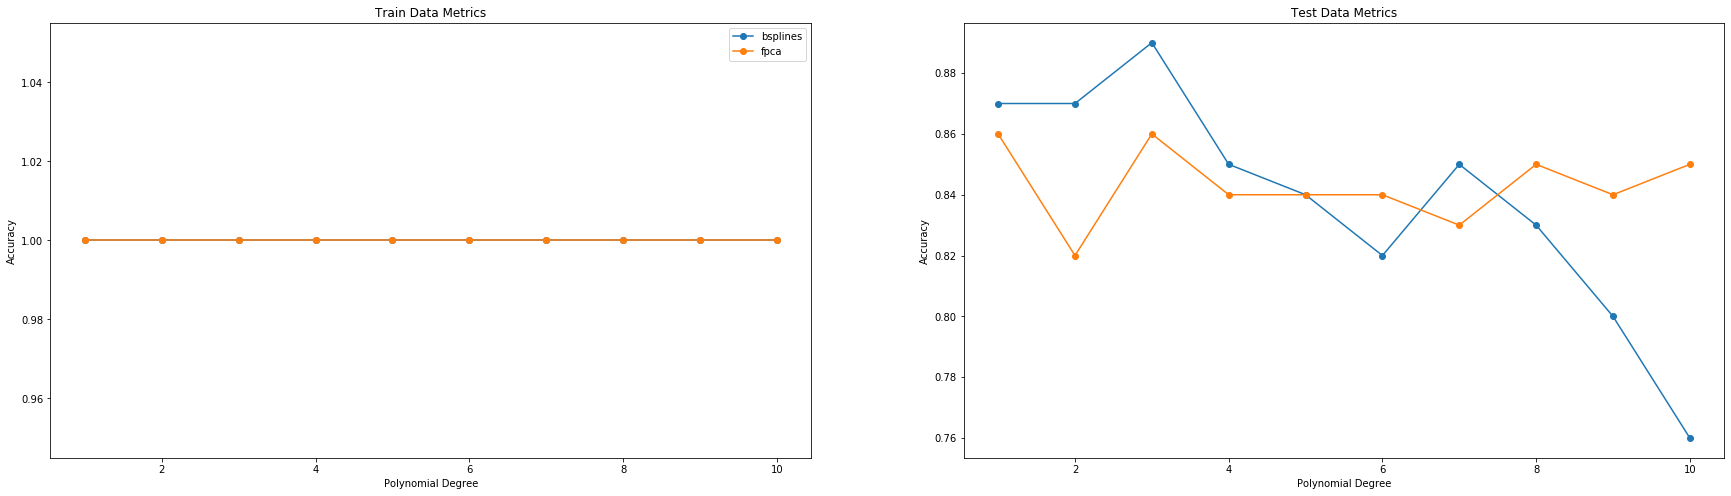

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,8))
ax1 = plt.subplot(121)
ax1.plot(degrees, bs_train_accs, label='bsplines', marker='o')
ax1.plot(degrees, fpca_train_accs, label='fpca', marker='o')
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('Accuracy')
ax1.set_title('Train Data Metrics')
plt.legend()

ax2 = plt.subplot(122)
ax2.plot(degrees, bs_test_accs, label='bsplines', marker='o')
ax2.plot(degrees, fpca_test_accs, label='fpca', marker='o')
ax2.set_xlabel('Polynomial Degree')
ax2.set_ylabel('Accuracy')
ax2.set_title('Test Data Metrics')
plt.legend

plt.show()

We varied polynomial degree from order 1 to 10th degree. This seems to only greatly affect the Bspline method where it is evident that the higher order polynomial greatly overfits the training data. We can see accuracy on the test set drop greatly as polynomial degree increses. The lowest accuracy of the Bsplines method coming with the highest order polynomial

## Effects of Number of Knots on Accuracy

In [24]:
num_knots = range(2,51)
bs_train_accs = []
fpca_train_accs = []

bs_test_accs = []
fpca_test_accs= []

for knot in num_knots:
    knots = np.linspace(0,1,knot)
    bs = fBSplines(x=Xtrain, y=ytrain).fit_splines(knots=knots, degree=3)
    bs.train(clf=clf)
    
    fpca = FPCA(x=Xtrain, y=ytrain).fit_splines(knots=knots, degree=3, show_fit=False)
    fpca.PCA(n_components=3)
    fpca.train(clf)
    
    bs_train_preds = bs.predict(predict_train_data=True)
    fpca_train_preds = fpca.predict(predict_train_data=True)
    
    acc_train_bs = accuracy_score(ytrain, bs_train_preds)
    acc_train_fpca = accuracy_score(ytrain, fpca_train_preds)
    
    bs_train_accs.append(acc_train_bs)
    fpca_train_accs.append(acc_train_fpca)
    
    
    
    Xtest_bs = bs.transform(Xtest)
    Xtest_fpca = fpca.transform(Xtest)
    
    bs_preds = bs.predict(Xtest_bs)
    fpca_preds = fpca.predict(Xtest_fpca)
    
    acc_test_bs = accuracy_score(ytest, bs_preds)
    acc_test_fpca = accuracy_score(ytest, fpca_preds)
    
    bs_test_accs.append(acc_test_bs)
    fpca_test_accs.append(acc_test_fpca)

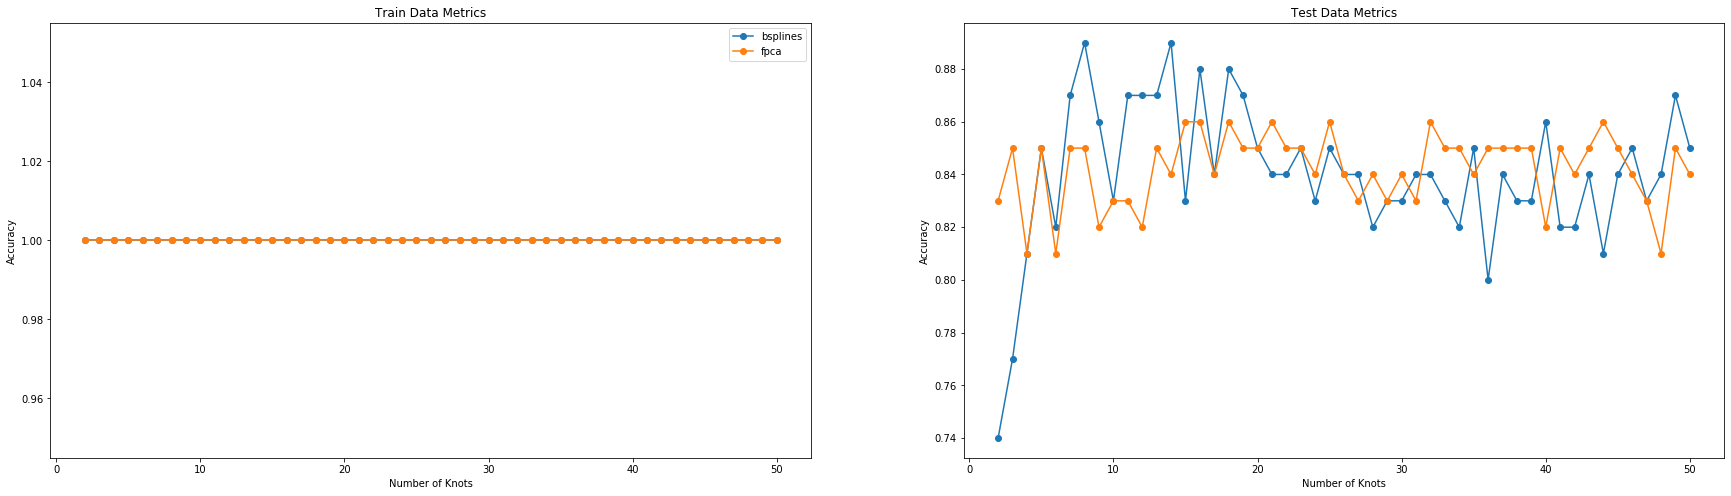

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,8))
ax1 = plt.subplot(121)
ax1.plot(num_knots, bs_train_accs, label='bsplines', marker='o')
ax1.plot(num_knots, fpca_train_accs, label='fpca', marker='o')
ax1.set_xlabel('Number of Knots')
ax1.set_ylabel('Accuracy')
ax1.set_title('Train Data Metrics')
plt.legend()

ax2 = plt.subplot(122)
ax2.plot(num_knots, bs_test_accs, label='bsplines', marker='o')
ax2.plot(num_knots, fpca_test_accs, label='fpca', marker='o')
ax2.set_xlabel('Number of Knots')
ax2.set_ylabel('Accuracy')
ax2.set_title('Test Data Metrics')
plt.legend

plt.show()

We varied the number of knows from 2 to 50. This seems to not have as much effect on the bias/variance tradeoff as the polynomial degree effect did.

# Results
It appears that the B-spline method achieves the greatest performance with polynomial degree 3 and 13 knots to create the basis functions. With these parameters, it exceeds the best peforming FPCA model with any combination of parameters